In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from collections import defaultdict
from collections import Counter
torch.manual_seed(1)
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, DataLoader


# Defining GPU Device
cuda_device = torch.device("cuda")

# **1. Data Preparation**
  Data cleansing and transformation </br>
    CIFAR-10 Dataset is dowloaded and imported from pytorch. So the dataset is

already clean and preprocessed by default.</br>
    a. There are no corrupted Images present.</br>
    b. There are no duplicate Images.</br>
    c. Labels for all the images are correct
*   Data splitting (i.e., training, validation, and test splits)



In [ ]:
image_size = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]


compose_train = transforms.Compose([transforms.Resize((image_size, image_size)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


compose_test = transforms.Compose([transforms.Resize((image_size,image_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

In [ ]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=compose_train)

#Split training dataset into 70% training and 30% validation
cifar10_train_size = int(0.7 * len(cifar10))  # 70% for training
cifar10_val_size = len(cifar10) - cifar10_train_size  # 30% for validation
train_data, val_data = random_split(cifar10, [cifar10_train_size, cifar10_val_size])
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(val_data))
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=compose_test)
print("Number of testing samples: ", len(test_data))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Files already downloaded and verified
Number of training samples:  35000
Number of validation samples:  15000
Files already downloaded and verified
Number of testing samples:  10000


# 2. Exploratory Data Analysis (EDA) (10 points)


In [ ]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.grid('False')
    plt.show()

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

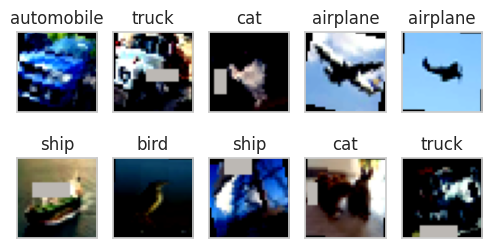

In [ ]:
# Different classes in CIPHAR 10 dataset.
classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

# Define an iterable on the data
data_iterable = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(data_iterable) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(6, 3))

# Lets plot 50 images from our train_dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    # Note: imshow cant print tensor !
    # Lets convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

Files already downloaded and verified
Files already downloaded and verified


<ipython-input-31-1321e23dfaa9>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(classes), y=[train_class_distribution[i] for i in range(10)], palette='viridis')


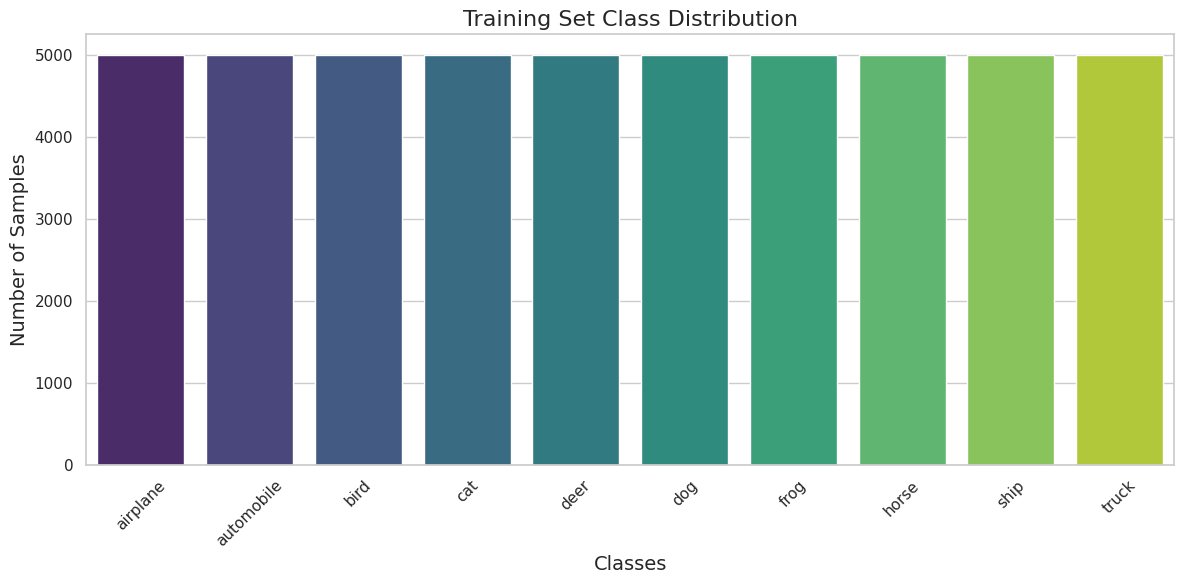

<ipython-input-31-1321e23dfaa9>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(classes), y=[test_class_distribution[i] for i in range(10)], palette='plasma')


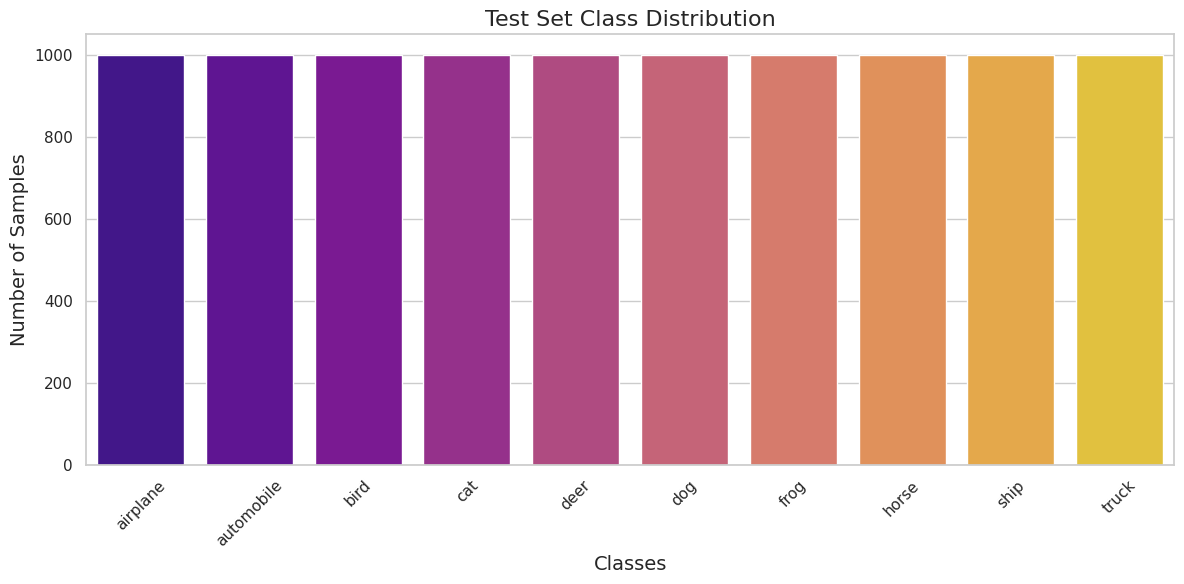

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load CIFAR-10 train and test datasets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Retrieve data and labels for train and test datasets
train_data_eda = np.array([image.numpy() for image, _ in train_dataset])
train_labels = np.array([label for _, label in train_dataset])

test_data_eda = np.array([image.numpy() for image, _ in test_dataset])
test_labels = np.array([label for _, label in test_dataset])

# Set seaborn style for plots
sns.set(style='whitegrid')

# Part (a) Descriptive Statistics

# 1. Class distribution for training and test datasets
train_class_distribution = Counter(train_labels)
test_class_distribution = Counter(test_labels)
classes = train_dataset.classes


<ipython-input-34-fed9b5926261>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax[0], x=list(classes), y=[train_class_distribution[i] for i in range(10)], palette='viridis')
<ipython-input-34-fed9b5926261>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax[1], x=list(classes), y=[test_class_distribution[i] for i in range(10)], palette='plasma')


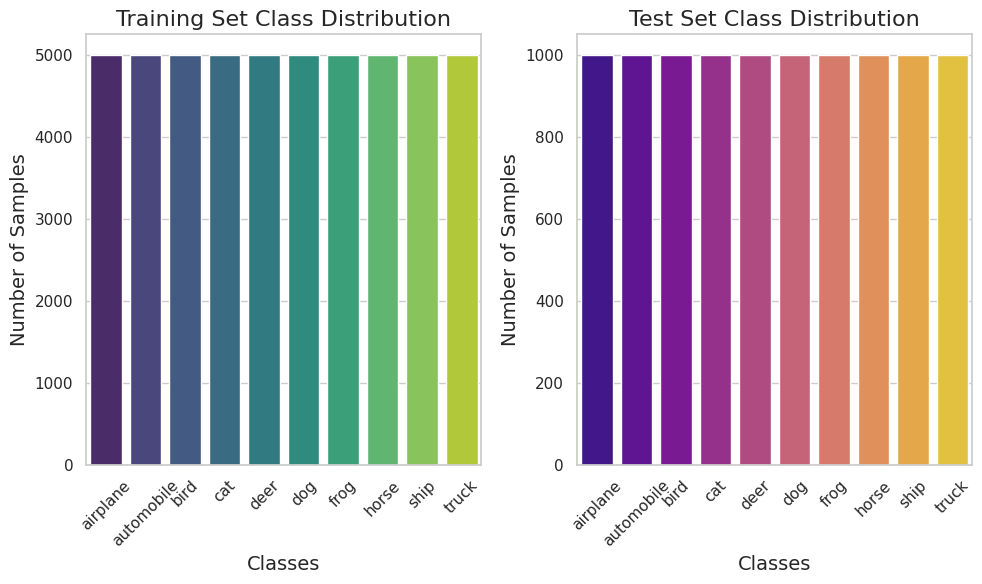

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))  # 1 row, 2 columns

# Plot the training set class distribution
sns.barplot(ax=ax[0], x=list(classes), y=[train_class_distribution[i] for i in range(10)], palette='viridis')
ax[0].set_title('Training Set Class Distribution', fontsize=16)
ax[0].set_xlabel('Classes', fontsize=14)
ax[0].set_ylabel('Number of Samples', fontsize=14)
ax[0].tick_params(axis='x', rotation=45)

# Plot the test set class distribution
sns.barplot(ax=ax[1], x=list(classes), y=[test_class_distribution[i] for i in range(10)], palette='plasma')
ax[1].set_title('Test Set Class Distribution', fontsize=16)
ax[1].set_xlabel('Classes', fontsize=14)
ax[1].set_ylabel('Number of Samples', fontsize=14)
ax[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

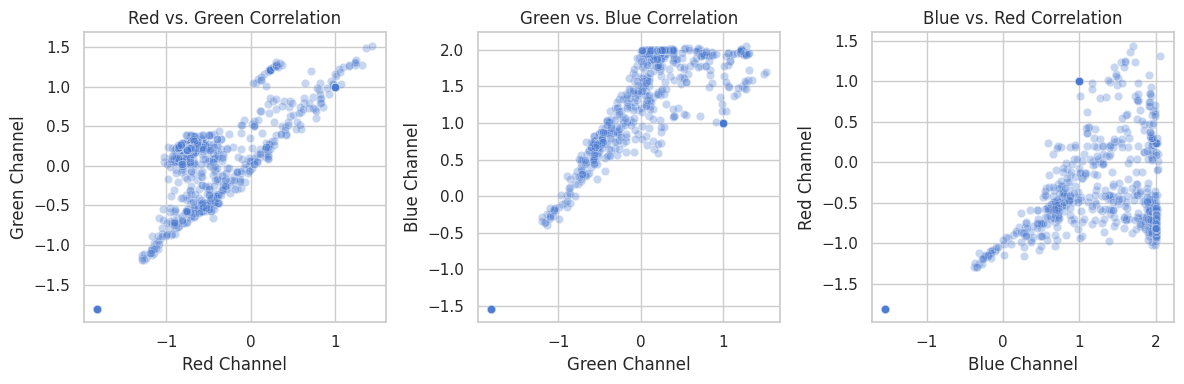

In [ ]:
def plot_channel_correlation(dataset, num_samples=500):
    images, _ = zip(*[dataset[i] for i in range(num_samples)])
    images = np.stack([img.numpy() for img in images])

    r_channel = images[:, 0, :, :].flatten()
    g_channel = images[:, 1, :, :].flatten()
    b_channel = images[:, 2, :, :].flatten()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=r_channel[:1000], y=g_channel[:1000], alpha=0.3)
    plt.xlabel("Red Channel")
    plt.ylabel("Green Channel")
    plt.title("Red vs. Green Correlation")

    plt.subplot(1, 3, 2)
    sns.scatterplot(x=g_channel[:1000], y=b_channel[:1000], alpha=0.3)
    plt.xlabel("Green Channel")
    plt.ylabel("Blue Channel")
    plt.title("Green vs. Blue Correlation")

    plt.subplot(1, 3, 3)
    sns.scatterplot(x=b_channel[:1000], y=r_channel[:1000], alpha=0.3)
    plt.xlabel("Blue Channel")
    plt.ylabel("Red Channel")
    plt.title("Blue vs. Red Correlation")

    plt.tight_layout()
    plt.show()

plot_channel_correlation(train_data)

Variance preserved by the first 3 PCA components: 47.06%


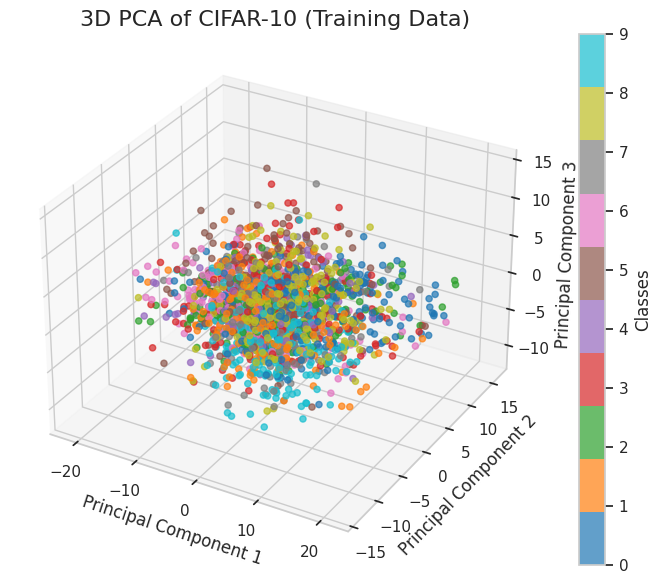

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Reshape data for PCA
train_data_flattened = train_data_eda.reshape(train_data_eda.shape[0], -1)
test_data_flattened = test_data_eda.reshape(test_data_eda.shape[0], -1)

# PCA for training and test datasets with 3 components
pca = PCA(n_components=3)
train_data_pca_3d = pca.fit_transform(train_data_flattened[:2000])  # Use a subset for visualization (2000 samples)
test_data_pca_3d = pca.fit_transform(test_data_flattened[:2000])    # Use a subset for visualization (2000 samples)

# Calculate the variance explained by the first 3 components
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = explained_variance_ratio.sum() * 100

# Print the amount of variance preserved
print(f"Variance preserved by the first 3 PCA components: {total_variance_explained:.2f}%")

# 3D PCA Visualization for Training Data
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_data_pca_3d[:, 0], train_data_pca_3d[:, 1], train_data_pca_3d[:, 2],
                     c=train_labels[:2000], cmap='tab10', alpha=0.7)
ax.set_title('3D PCA of CIFAR-10 (Training Data)', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)
plt.colorbar(scatter, ticks=range(10), label='Classes')
plt.tight_layout()
plt.show()

#Models

#**Convolution Neural Network**

In [ ]:
def train_model(model, train_loader, validation_loader, test_loader, optimizer, n_epochs=20):
    N_train = len(train_loader.dataset)
    N_val = len(validation_loader.dataset)
    N_test = len(test_loader.dataset)

    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []

    model = model.to(cuda_device)

    for epoch in range(n_epochs):
        # Training phase
        train_cost = 0
        correct_train = 0
        model.train()
        for x, y in train_loader:
            x, y = x.to(cuda_device), y.to(cuda_device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            train_cost += loss.item()

            # Compute training accuracy
            _, yhat = torch.max(z.data, 1)
            correct_train += (yhat == y).sum().item()

        train_cost /= len(train_loader)
        train_loss_list.append(train_cost)

        train_accuracy = correct_train / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation phase
        correct_val = 0
        val_cost = 0
        model.eval()
        with torch.no_grad():
            for x_val, y_val in validation_loader:
                x_val, y_val = x_val.to(cuda_device), y_val.to(cuda_device)
                z = model(x_val)
                val_loss = criterion(z, y_val)
                _, yhat = torch.max(z.data, 1)
                correct_val += (yhat == y_val).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(validation_loader)
        val_loss_list.append(val_cost)

        val_accuracy = correct_val / N_val
        val_accuracy_list.append(val_accuracy)

        print(f"Epoch {epoch + 1}: Training Loss = {train_cost:.4f}, Validation Loss = {val_cost:.4f}, "
              f"Training Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")

    # Test phase
    y_true = []
    y_pred = []
    test_cost = 0
    correct_test = 0

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(cuda_device), y_test.to(cuda_device)
            z = model(x_test)
            test_loss = criterion(z, y_test)
            test_cost += test_loss.item()
            _, yhat = torch.max(z.data, 1)
            correct_test += (yhat == y_test).sum().item()
            y_true.extend(y_test.cpu().numpy())
            y_pred.extend(yhat.cpu().numpy())

    test_cost /= len(test_loader)
    test_accuracy = correct_test / N_test

    print(f"Test Loss: {test_cost:.4f} | Test Accuracy: {test_accuracy * 100:.2f}%")

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)])

    return train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list, test_accuracy, test_cost, conf_matrix, report

In [ ]:
class CNN(nn.Module):
    '''
    CNN Model V1:
    1. 2 convolution + max pool layers
    2. 1 fully connected layers
    3. Default runtime using 0 momentum and 0 dropout value
    '''

    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        # Calculation of how we got 8*8 is mentioned in the below comment

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return(x)

In [ ]:
# Define the model
model = CNN(out_1=32, out_2=64, number_of_classes = 10)

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the model
train_accuracy_list_cnn1, val_accuracy_list_cnn1, train_loss_list_cnn1, val_loss_list_cnn1, test_accuracy_cnn1, test_cost_cnn1, conf_matrix_cnn1, report_cnn1 = train_model(model=model,n_epochs=20,train_loader=train_loader,validation_loader=val_loader,test_loader=test_loader,optimizer=optimizer)


Epoch 1: Training Loss = 1.6887, Validation Loss = 1.6280, Training Accuracy = 39.85%, Validation Accuracy = 41.85%
Epoch 2: Training Loss = 1.4002, Validation Loss = 1.4641, Training Accuracy = 50.40%, Validation Accuracy = 49.17%
Epoch 3: Training Loss = 1.4815, Validation Loss = 1.4374, Training Accuracy = 48.88%, Validation Accuracy = 49.88%
Epoch 4: Training Loss = 1.3172, Validation Loss = 1.4090, Training Accuracy = 53.69%, Validation Accuracy = 51.80%
Epoch 5: Training Loss = 1.2620, Validation Loss = 1.2910, Training Accuracy = 56.09%, Validation Accuracy = 54.71%
Epoch 6: Training Loss = 1.2331, Validation Loss = 1.2691, Training Accuracy = 57.13%, Validation Accuracy = 55.88%
Epoch 7: Training Loss = 1.2026, Validation Loss = 1.3408, Training Accuracy = 58.09%, Validation Accuracy = 54.03%
Epoch 8: Training Loss = 1.1874, Validation Loss = 1.2565, Training Accuracy = 58.56%, Validation Accuracy = 57.03%
Epoch 9: Training Loss = 1.1708, Validation Loss = 1.2851, Training Accu

In [ ]:
print(f"Final Test Accuracy: {round(test_accuracy_cnn1 * 100, 2)}%")
print(f"Final Test Loss: {round(test_cost_cnn1, 4)}")

Final Test Accuracy: 65.86%
Final Test Loss: 1.0877


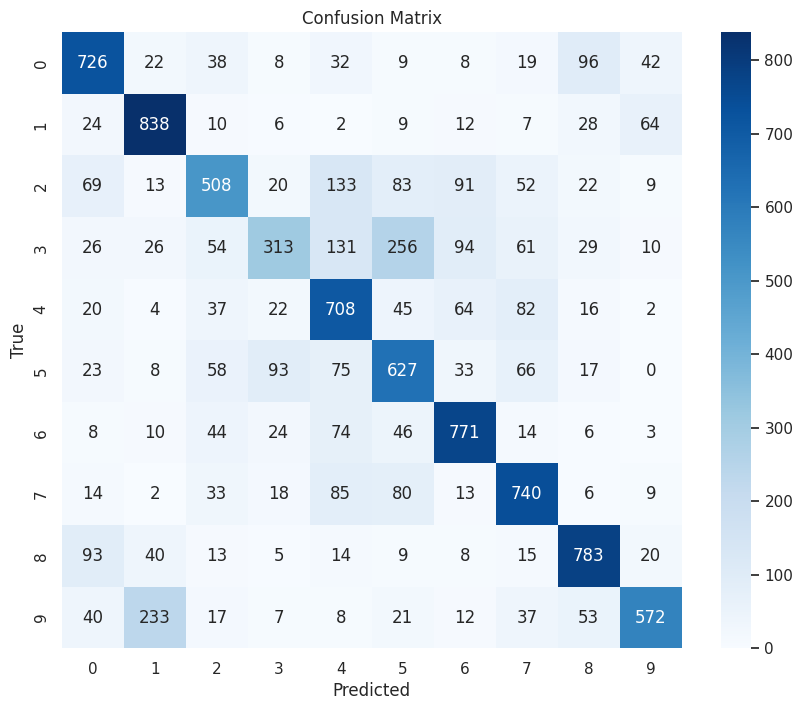

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1000
           1       0.70      0.84      0.76      1000
           2       0.63      0.51      0.56      1000
           3       0.61      0.31      0.41      1000
           4       0.56      0.71      0.63      1000
           5       0.53      0.63      0.57      1000
           6       0.70      0.77      0.73      1000
           7       0.68      0.74      0.71      1000
           8       0.74      0.78      0.76      1000
           9       0.78      0.57      0.66      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



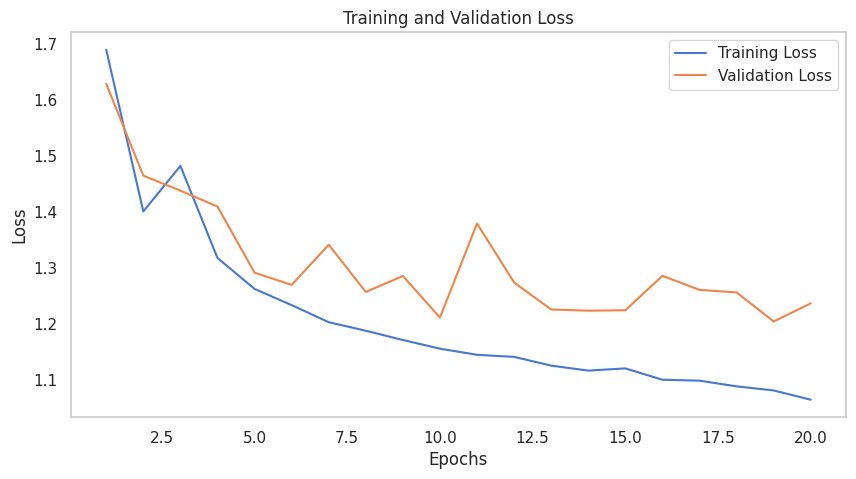

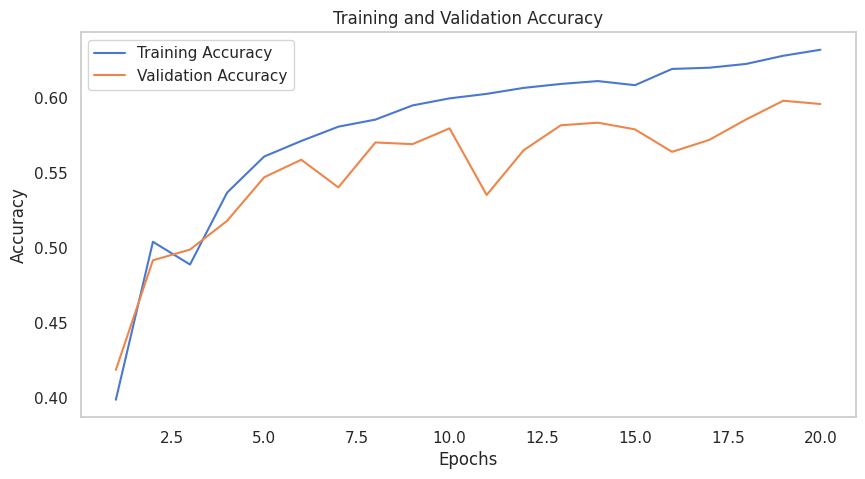

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn1, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(report_cnn1)

# Plot training history
def plot_training_history(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.legend()
    plt.show()

plot_training_history(train_loss_list_cnn1, val_loss_list_cnn1, train_accuracy_list_cnn1, val_accuracy_list_cnn1)


CNN Model-2

In [ ]:
class CNN_V3_V2(nn.Module):

    '''
    CNN Model V3-V2:
    1. 3 convolution & max pool layers
    2. 3 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        # 8x8 will change to 4x4 as we added a convolution & max pool layer refer calculation comment above
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)

        return(x)

In [ ]:
model_mmtv4 = CNN_V3_V2(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)

# Define the model hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv4.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
train_accuracy_list_cnn2, val_accuracy_list_cnn2, train_loss_list_cnn2, val_loss_list_cnn2, test_accuracy_cnn2, test_cost_cnn2, conf_matrix_cnn2, report_cnn2=train_model(model=model_mmtv4, n_epochs=20, train_loader=train_loader,test_loader=test_loader, validation_loader=val_loader, optimizer=optimizer)

Epoch 1: Training Loss = 1.8615, Validation Loss = 1.7153, Training Accuracy = 30.94%, Validation Accuracy = 37.27%
Epoch 2: Training Loss = 1.5222, Validation Loss = 1.3844, Training Accuracy = 44.83%, Validation Accuracy = 49.65%
Epoch 3: Training Loss = 1.3829, Validation Loss = 1.2554, Training Accuracy = 50.71%, Validation Accuracy = 55.37%
Epoch 4: Training Loss = 1.2999, Validation Loss = 1.2268, Training Accuracy = 54.31%, Validation Accuracy = 57.19%
Epoch 5: Training Loss = 1.2370, Validation Loss = 1.2261, Training Accuracy = 56.70%, Validation Accuracy = 56.37%
Epoch 6: Training Loss = 1.2092, Validation Loss = 1.1834, Training Accuracy = 58.27%, Validation Accuracy = 58.49%
Epoch 7: Training Loss = 1.1804, Validation Loss = 1.1584, Training Accuracy = 59.29%, Validation Accuracy = 60.18%
Epoch 8: Training Loss = 1.1765, Validation Loss = 1.1209, Training Accuracy = 59.58%, Validation Accuracy = 60.90%
Epoch 9: Training Loss = 1.1635, Validation Loss = 1.2108, Training Accu

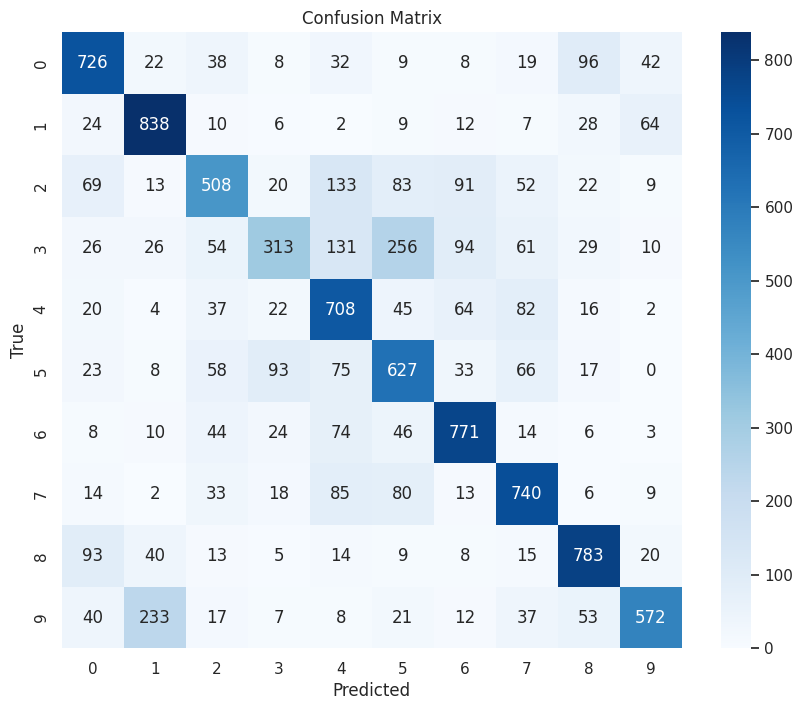

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1000
           1       0.70      0.84      0.76      1000
           2       0.63      0.51      0.56      1000
           3       0.61      0.31      0.41      1000
           4       0.56      0.71      0.63      1000
           5       0.53      0.63      0.57      1000
           6       0.70      0.77      0.73      1000
           7       0.68      0.74      0.71      1000
           8       0.74      0.78      0.76      1000
           9       0.78      0.57      0.66      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



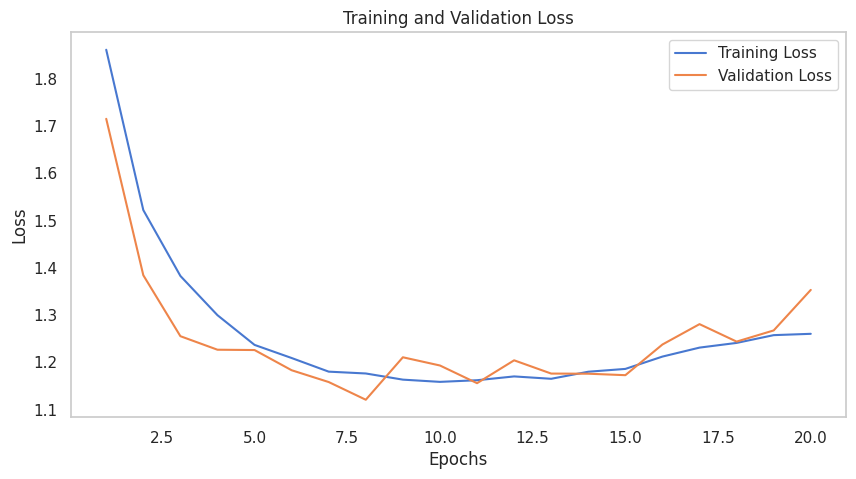

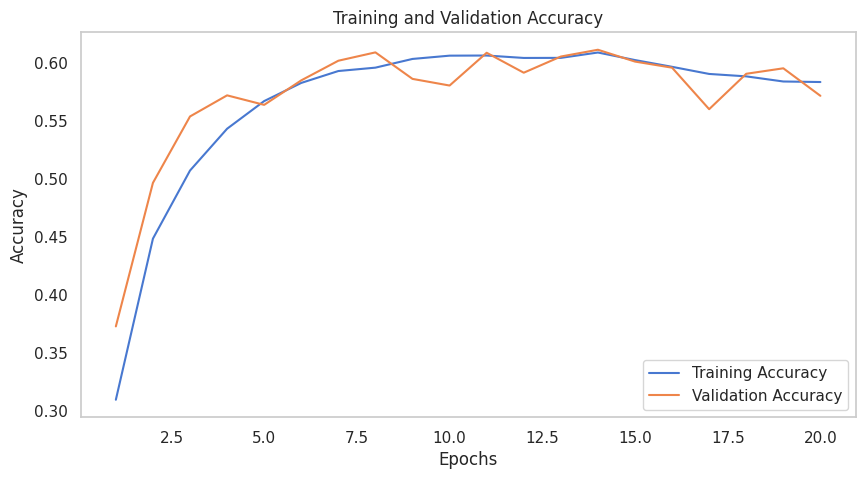

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn1, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(report_cnn1)

# Plot training history
def plot_training_history(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.legend()
    plt.show()

plot_training_history(train_loss_list_cnn2, val_loss_list_cnn2, train_accuracy_list_cnn2, val_accuracy_list_cnn2)


CNN Model-3

In [ ]:
class CNN_V3_V4(nn.Module):
    """
    Adding one more hidden layer & dropout value & one more convolution layer
    Total 3 hidden layers, 3 convolution layer & Batch Normalization
    """
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)

        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)

        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)

        return(x)

In [ ]:
model_mmtv5 = CNN_V3_V4(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
train_accuracy_list_cnnb, val_accuracy_list_cnnb, train_loss_list_cnnb, val_loss_list_cnnb, test_accuracy_cnnb, test_cost_cnnb, conf_matrix_cnnb, report_cnnb=train_model(model=model_mmtv5, n_epochs=20, train_loader=train_loader,test_loader=test_loader, validation_loader=val_loader, optimizer=optimizer)

Epoch 1: Training Loss = 1.7286, Validation Loss = 1.4772, Training Accuracy = 36.74%, Validation Accuracy = 46.40%
Epoch 2: Training Loss = 1.4927, Validation Loss = 1.2995, Training Accuracy = 46.10%, Validation Accuracy = 53.12%
Epoch 3: Training Loss = 1.3909, Validation Loss = 1.2298, Training Accuracy = 50.06%, Validation Accuracy = 56.89%
Epoch 4: Training Loss = 1.3120, Validation Loss = 1.1549, Training Accuracy = 53.17%, Validation Accuracy = 59.15%
Epoch 5: Training Loss = 1.2560, Validation Loss = 1.0841, Training Accuracy = 55.33%, Validation Accuracy = 62.04%
Epoch 6: Training Loss = 1.2101, Validation Loss = 1.0420, Training Accuracy = 57.24%, Validation Accuracy = 63.24%
Epoch 7: Training Loss = 1.1684, Validation Loss = 1.0392, Training Accuracy = 59.17%, Validation Accuracy = 63.35%
Epoch 8: Training Loss = 1.1420, Validation Loss = 0.9862, Training Accuracy = 60.05%, Validation Accuracy = 65.23%
Epoch 9: Training Loss = 1.1146, Validation Loss = 0.9433, Training Accu

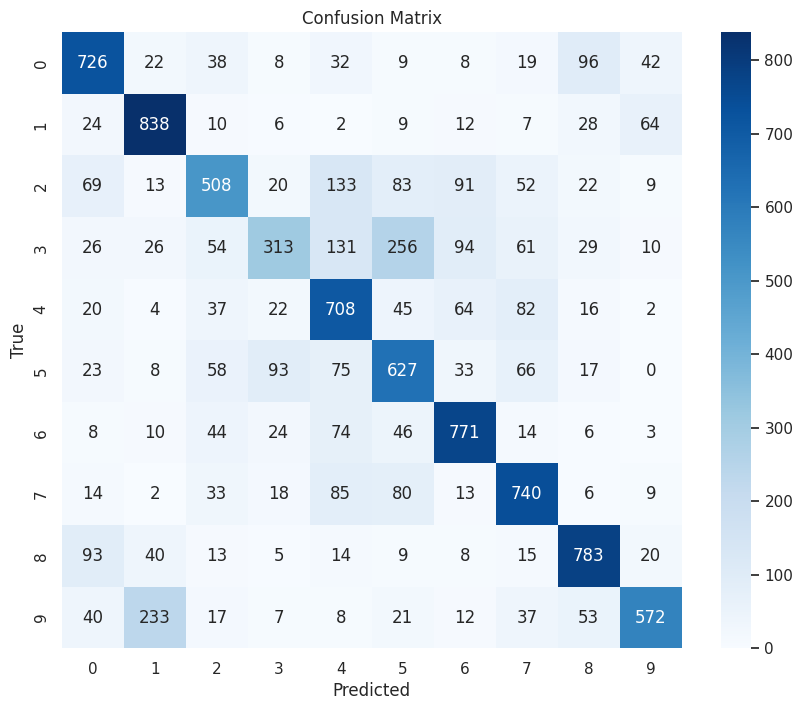

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1000
           1       0.70      0.84      0.76      1000
           2       0.63      0.51      0.56      1000
           3       0.61      0.31      0.41      1000
           4       0.56      0.71      0.63      1000
           5       0.53      0.63      0.57      1000
           6       0.70      0.77      0.73      1000
           7       0.68      0.74      0.71      1000
           8       0.74      0.78      0.76      1000
           9       0.78      0.57      0.66      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



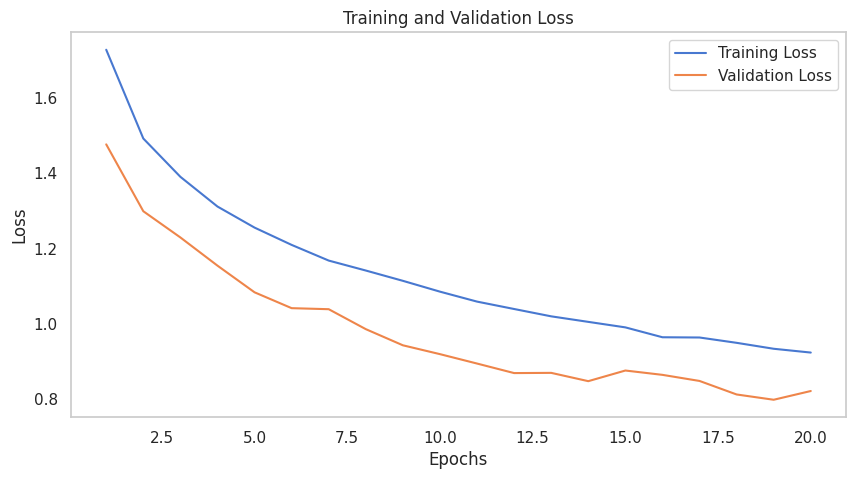

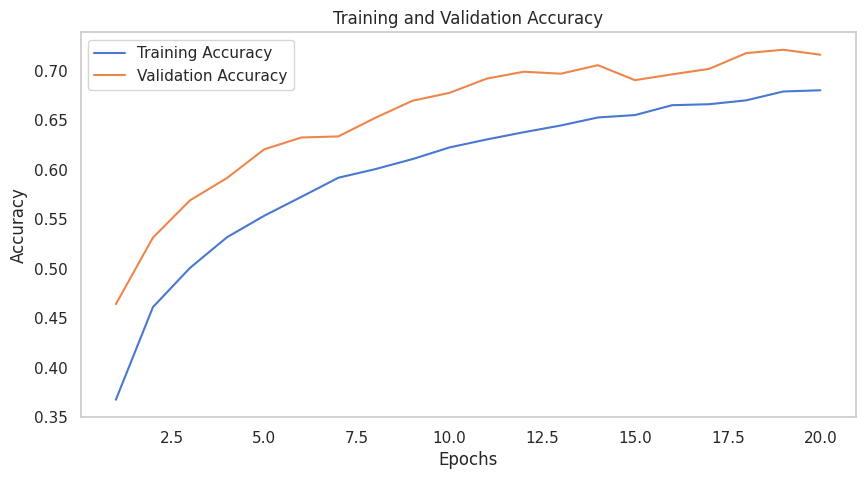

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn1, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(report_cnn1)

# Plot training history
def plot_training_history(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.legend()
    plt.show()

plot_training_history(train_loss_list_cnnb, val_loss_list_cnnb,train_accuracy_list_cnnb, val_accuracy_list_cnnb)


Model-2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

dataset_path = '/content/drive/MyDrive/datasets/cifar10'

# Check if the dataset is already downloaded
if not os.path.exists(os.path.join(dataset_path, 'cifar-10-batches-py')):
    print("Dataset not found. Downloading...")
    download = True
else:
    print("Dataset exists!")
    download = False

if not os.path.exists(os.path.join(dataset_path, 'cifar-10-batches-py/test_batch')):
    print("Test dataset not found. Downloading...")
    download_test = True
else:
    print("Test dataset exists!")
    download_test = False
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet input
    transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

cifar10 = datasets.CIFAR10(root=dataset_path, train=True, download=download, transform=transform)

#Split training dataset into 70% training and 30% validation
cifar10_train_size = int(0.7 * len(cifar10))  # 70% for training
cifar10_val_size = len(cifar10) - cifar10_train_size ; # 30% for validation
cifar10_train_dataset, cifar10_val_dataset = random_split(cifar10, [cifar10_train_size, cifar10_val_size])
print("Number of training samples: ", len(cifar10_train_dataset))
print("Number of validation samples: ", len(cifar10_val_dataset))
cifar10_test_dataset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=download_test, transform=transform)
print("Number of testing samples: ", len(cifar10_test_dataset))

Dataset exists!
Test dataset exists!
Number of training samples:  35000
Number of validation samples:  15000
Number of testing samples:  10000


In [ ]:
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=32, shuffle=True)
cifar10_val_loader = DataLoader(cifar10_val_dataset, batch_size=32, shuffle=False)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=32, shuffle=False)

In [ ]:
model_path = '/content/drive/MyDrive/datasets/cifar10/resnet18_complete.pth'
if not os.path.exists(model_path):
    # Load the pre-trained ResNet-18 model
    resnet = torchvision.models.resnet18(pretrained=True)

    # Remove the final fully connected classification layer
    resnet.fc = torch.nn.Identity()

    # Move model to the appropriate device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    resnet = resnet.to(device)

    # Set ResNet to evaluation mode
    resnet.eval()

    # Save the entire model (architecture + weights)
    torch.save(resnet, model_path)
    print("Model saved to drive.")
else:
    # Load the entire saved model
    resnet = torch.load(model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    resnet = resnet.to(device)
    resnet.eval()
    print("Model loaded from drive.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


Model saved to drive.


In [ ]:
#User defined function for extracting features from CIFAR 10 Dataset
import numpy as np
def extract_features_cifar10(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = resnet(images)  # Extract features
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features).squeeze(), np.hstack(labels)

cifar10_train_features, cifar10_train_labels = extract_features_cifar10(cifar10_train_loader)
cifar10_val_features, cifar10_val_labels = extract_features_cifar10(cifar10_val_loader)
cifar10_test_features, cifar10_test_labels = extract_features_cifar10(cifar10_test_loader)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cifar10_train_features_scaled = scaler.fit_transform(cifar10_train_features)
cifar10_val_features_scaled= scaler.transform(cifar10_val_features)
cifar10_test_features_scaled = scaler.transform(cifar10_test_features)

In [ ]:
#Hyperparameter Tuning
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import torch
import os
from sklearn.model_selection import train_test_split
import joblib

# Subsample the training data (e.g., use 20%)
X_train_subset, _, y_train_subset, _ = train_test_split(cifar10_train_features, cifar10_train_labels, train_size=0.2, random_state=42)

# Define a function to save checkpoints
def save_checkpoint(model, path):
    joblib.dump(model, path)
    print("Checkpoint saved!")

# Function to load model from checkpoint
def load_checkpoint(path):
    print("Loading checkpoint...")
    return joblib.load(path)

# Define a function to perform randomized search with checkpointing
def randomized_search_with_checkpointing(X_train, y_train, param_dist, n_iter=5, cv=3, model_save_path='/content/drive/MyDrive/datasets/cifar10/svm_model_checkpoint.pkl'):
    svm = SVC(kernel='rbf')  # Initialize model

    # Load checkpoint if it exists
    try:
        best_model = load_checkpoint(model_save_path)  # Load saved model
        print("Resuming from checkpoint...")
        randomized_search = RandomizedSearchCV(
            svm,
            param_distributions=param_dist,
            n_iter=n_iter - 1,  # Reduce remaining iterations
            cv=cv,
            scoring='accuracy',
            verbose=2,
            n_jobs=-1
        )
    except FileNotFoundError:
        # If no checkpoint exists, start fresh
        print("No checkpoint found. Starting from scratch.")
        randomized_search = RandomizedSearchCV(
            svm,
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=cv,
            scoring='accuracy',
            verbose=2,
            n_jobs=-1
        )
        best_model = None

    # Fit the model and save checkpoints after each iteration
    for iteration in range(n_iter):
        if best_model is None or iteration > 0:
            print(f"Iteration {iteration + 1} of {n_iter}")
            randomized_search.fit(X_train, y_train)  # Fit the model with the current random search

            # Update the best model based on best score from the search
            if best_model is None or randomized_search.best_score_ > randomized_search.score(X_train, y_train):
                best_model = randomized_search.best_estimator_

            # Save checkpoint after every iteration (or as needed)
            save_checkpoint(best_model, model_save_path)

    return best_model

# Example usage:
param_dist = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 0.1, 1]
}

# Assuming you have defined X_train_subset and y_train_subset
svm_best = randomized_search_with_checkpointing(X_train_subset, y_train_subset, param_dist)

Loading checkpoint...
No checkpoint found. Starting from scratch.
Iteration 1 of 5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Checkpoint saved!
Iteration 2 of 5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Checkpoint saved!
Iteration 3 of 5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Checkpoint saved!
Iteration 4 of 5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Checkpoint saved!
Iteration 5 of 5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Checkpoint saved!


AttributeError: 'SVC' object has no attribute 'best_params_'

In [ ]:
#Hyperparameter Tuning
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

from sklearn.model_selection import train_test_split

# Subsample the training data (e.g., use 20%)
X_train_subset, _, y_train_subset, _ = train_test_split(cifar10_train_features_scaled, cifar10_train_labels, train_size=0.2, random_state=42)

# Define the parameter distribution instead of a grid
param_dist = {
    'C': uniform(0.1, 10),    # Random values between 0.1 and 10
    'gamma': ['scale', 0.1, 1]  # Use predefined values
}

# Use RandomizedSearchCV with 3-fold cross-validation
randomized_search = RandomizedSearchCV(
    SVC(kernel='rbf'),
    param_distributions=param_dist,
    n_iter=5,               # Number of parameter combinations to sample
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1                # Use all available processors
)

randomized_search.fit(X_train_subset, y_train_subset)
print(f"Best Parameters: {randomized_search.best_params_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'C': 8.486123788362463, 'gamma': 'scale'}


In [ ]:
from sklearn.metrics import accuracy_score
best_params = randomized_search.best_params_
C_best = best_params['C']
gamma_best = best_params['gamma']

# Initialize the SVM model with the best hyperparameters
svm_final_model = SVC(kernel='rbf', C=C_best, gamma=gamma_best)

# Train the model on the entire training data
svm_final_model.fit(cifar10_train_features_scaled, cifar10_train_labels)

SVC(C=8.486123788362463)

In [ ]:
model_save_path = '/content/drive/MyDrive/datasets/cifar10/svm_final_model.pkl'
joblib.dump(svm_final_model, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/datasets/cifar10/svm_final_model.pkl


In [ ]:
# After training, evaluate the model on the test set
y_pred = svm_final_model.predict(cifar10_test_features_scaled)

# Evaluate accuracy
test_accuracy = accuracy_score(cifar10_test_labels, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 86.57%


In [ ]:
# Validate the model on validation set
y_pred_val = svm_final_model.predict(cifar10_val_features_scaled)

# Evaluate accuracy
test_accuracy = accuracy_score(cifar10_val_labels, y_pred_val)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 87.46%


# Resnet

In [ ]:
def train_mode_resnet(model, train_loader, validation_loader, test_loader, optimizer, n_epochs=20):
    N_train = len(train_loader.dataset)
    N_val = len(validation_loader.dataset)
    N_test = len(test_loader.dataset)

    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []

    model = model.to(cuda_device)

    for epoch in range(n_epochs):
        # Training phase
        train_cost = 0
        correct_train = 0
        model.train()
        for x, y in train_loader:
            x, y = x.to(cuda_device), y.to(cuda_device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            train_cost += loss.item()

            # Compute training accuracy
            _, yhat = torch.max(z.data, 1)
            correct_train += (yhat == y).sum().item()

        train_cost /= len(train_loader)
        train_loss_list.append(train_cost)

        train_accuracy = correct_train / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation phase
        correct_val = 0
        val_cost = 0
        model.eval()
        with torch.no_grad():
            for x_val, y_val in validation_loader:
                x_val, y_val = x_val.to(cuda_device), y_val.to(cuda_device)
                z = model(x_val)
                val_loss = criterion(z, y_val)
                _, yhat = torch.max(z.data, 1)
                correct_val += (yhat == y_val).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(validation_loader)
        val_loss_list.append(val_cost)

        val_accuracy = correct_val / N_val
        val_accuracy_list.append(val_accuracy)

        print(f"Epoch {epoch + 1}: Training Loss = {train_cost:.4f}, Validation Loss = {val_cost:.4f}, "
              f"Training Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")

    # Test phase
    y_true = []
    y_pred = []
    test_cost = 0
    correct_test = 0

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(cuda_device), y_test.to(cuda_device)
            z = model(x_test)
            test_loss = criterion(z, y_test)
            test_cost += test_loss.item()
            _, yhat = torch.max(z.data, 1)
            correct_test += (yhat == y_test).sum().item()
            y_true.extend(y_test.cpu().numpy())
            y_pred.extend(yhat.cpu().numpy())

    test_cost /= len(test_loader)
    test_accuracy = correct_test / N_test

    print(f"Test Loss: {test_cost:.4f} | Test Accuracy: {test_accuracy * 100:.2f}%")

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)])

    return train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list, test_accuracy, test_cost, conf_matrix, report

In [ ]:
IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# These values are mostly used by researchers as found to very useful in fast convergence


# https://pytorch.org/vision/stable/transforms.html
# We can try various transformation for good generalization of model
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])


# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform = composed_train)
validation_dataset = datasets.CIFAR10(root='./data',
                                   train=False,
                                   download=True,
                                   transform = composed_test)

# Create train and validation batch for training
training_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def resnet_34():
    # Define the resnet model
    resnet = torchvision.models.resnet34(pretrained=True)

    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)

    # Initialize with xavier uniform
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

model_mmtv6 = resnet_34()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv6.parameters(),
                            lr = learning_rate,
                            momentum = 0.2)

# Train the model
train_accuracy_list_res, val_accuracy_list_res, train_loss_list_res, val_loss_list_res, test_accuracy_res, test_cost_res, conf_matrix_res, report_res=train_mode_resnet(model=model_mmtv6, n_epochs=10, train_loader=training_loader,test_loader=validation_loader, validation_loader=validation_loader, optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Training Loss = 0.6865, Validation Loss = 0.3143, Training Accuracy = 79.58%, Validation Accuracy = 89.01%
Epoch 2: Training Loss = 0.2367, Validation Loss = 0.2545, Training Accuracy = 91.83%, Validation Accuracy = 91.53%
Epoch 3: Training Loss = 0.1728, Validation Loss = 0.1727, Training Accuracy = 94.06%, Validation Accuracy = 94.01%
Epoch 4: Training Loss = 0.1338, Validation Loss = 0.1770, Training Accuracy = 95.42%, Validation Accuracy = 94.39%
Epoch 5: Training Loss = 0.1106, Validation Loss = 0.2147, Training Accuracy = 96.06%, Validation Accuracy = 93.76%
Epoch 6: Training Loss = 0.0973, Validation Loss = 0.1694, Training Accuracy = 96.60%, Validation Accuracy = 94.95%
Epoch 7: Training Loss = 0.0784, Validation Loss = 0.1717, Training Accuracy = 97.27%, Validation Accuracy = 95.03%
Epoch 8: Training Loss = 0.0698, Validation Loss = 0.1899, Training Accuracy = 97.55%, Validation Accuracy = 94.64%
Epoch 9: Training Loss = 0.0638, Validation Loss = 0.1544, Training Accu

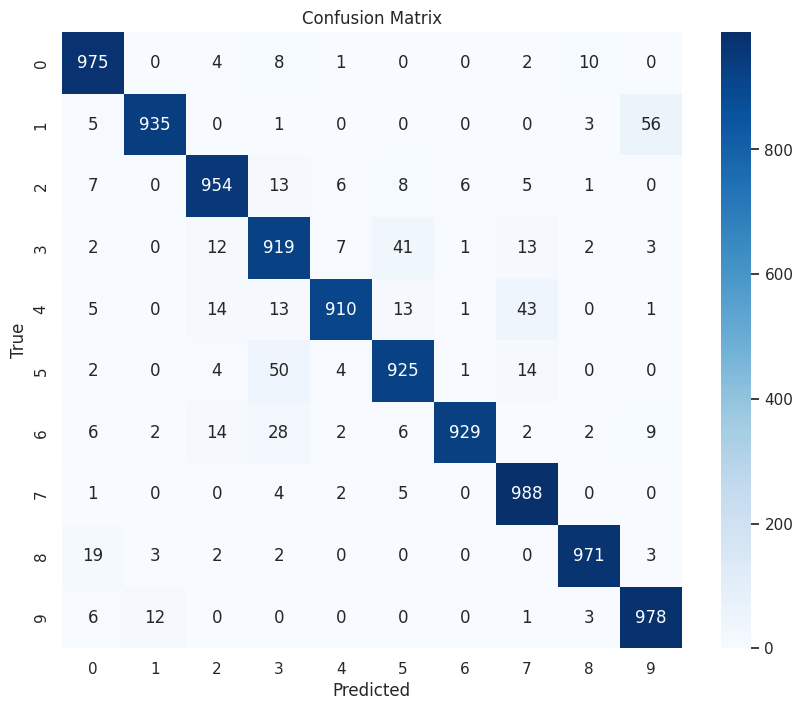

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1000
           1       0.98      0.94      0.96      1000
           2       0.95      0.95      0.95      1000
           3       0.89      0.92      0.90      1000
           4       0.98      0.91      0.94      1000
           5       0.93      0.93      0.93      1000
           6       0.99      0.93      0.96      1000
           7       0.93      0.99      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.93      0.98      0.95      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



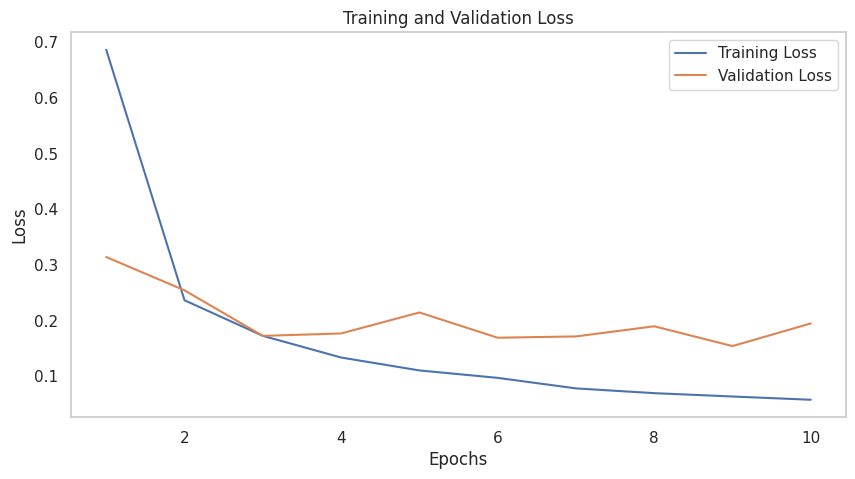

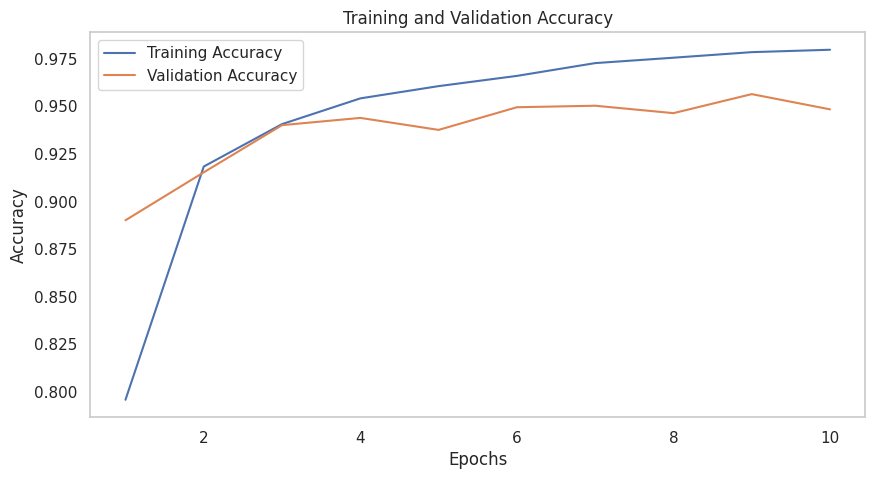

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_res, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(report_res)

# Plot training history
def plot_training_history(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.legend()
    plt.show()

plot_training_history(train_loss_list_res, val_loss_list_res, train_accuracy_list_res, val_accuracy_list_res)


**Model Interpretability**

TypeError: Invalid shape (32, 32, 32) for image data

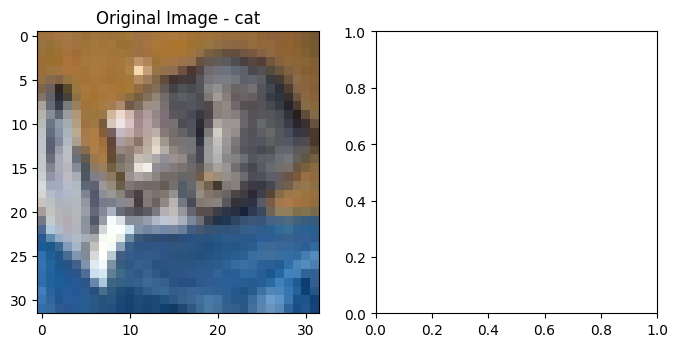

In [ ]:
from torchvision import models, transforms, datasets
import torch
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.autograd import Variable
import torchvision
from torch.autograd import Function

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Adjust output for 10 classes in CIFAR-10
model = model.to(cuda_device)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()
def compute_saliency_maps(model, data_loader):
    model.eval()
    for images, labels in data_loader:
        images = images.to(cuda_device).requires_grad_()
        labels = labels.to(cuda_device)

        # Forward pass
        output = model(images)
        loss = F.cross_entropy(output, labels)

        # Backward pass to get the gradient of the loss with respect to the input image
        model.zero_grad()
        loss.backward()

        # Get absolute value of the gradients
        saliency, _ = torch.max(images.grad.data.abs(), dim=1)
        saliency = saliency.squeeze().cpu().detach().numpy()

        # Plot the saliency map
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(images[0].cpu().detach().permute(1, 2, 0) * 0.247 + 0.4914)  # Unnormalize for visualization
        plt.title(f"Original Image - {classes[labels[0].item()]}")

        plt.subplot(1, 2, 2)
        plt.imshow(saliency, cmap=plt.cm.hot)
        plt.title("Saliency Map")
        plt.show()

        break  # Just visualize the first image for demonstration

# Compute and visualize saliency map
compute_saliency_maps(model, test_loader)
